In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from nilearn.connectome import sym_matrix_to_vec
from scipy.stats import pearsonr
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from cmath import isinf
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import multiprocessing
from skorch import NeuralNet
from skorch.callbacks import Callback
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def loader_to_numpy(loader):
    features, targets = [], []
    for feat, targ in loader:
        features.append(feat.numpy())
        targets.append(targ.numpy())
    return np.concatenate(features), np.concatenate(targets)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim_feat = 499500, input_dim_target = 1, hidden_dim_feat = 1000, output_dim = 2, dropout_rate = 0):
        super(MLP, self).__init__()
        
        # Xavier initialization for feature MLP
        self.feat_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_feat),
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        self.init_weights(self.feat_mlp)

        # Xavier initialization for target MLP
        self.target_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_target),
            nn.Linear(input_dim_target, output_dim)
        )
        self.init_weights(self.target_mlp)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x, y):
        features = self.feat_mlp(x)
        targets = self.target_mlp(y)
        features = nn.functional.normalize(features, p=2, dim=1)
        targets = nn.functional.normalize(targets, p=2, dim=1)
        return features, targets

In [5]:
class AgeEstimator(BaseEstimator):
    """ Define the age estimator on latent space network features.
    """
    def __init__(self):
        n_jobs = multiprocessing.cpu_count()
        self.age_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10.**np.arange(-2, 3)}, cv=5,
            scoring="r2", n_jobs=n_jobs)

    def fit(self, X, y):
        self.age_estimator.fit(X, y)
        return self.score(X, y), self.r2(X, y)

    def predict(self, X):
        y_pred = self.age_estimator.predict(X)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return mean_absolute_percentage_error(y, y_pred)
    
    def r2(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return r2_score(y, y_pred)

In [6]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, target_name, transform = None, train=True, train_size = 0.8, test_size=None, test_site = None, regions = None, threshold_mat = False, threshold_percent = None, random_state=42):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        # Load the entire dataset
        features = np.load(path_feat)      
        participant_data = pd.read_csv(path_target)
        targets = np.expand_dims(participant_data[target_name].values, axis = 1)
        

        # Split the dataset into training and test sets
        if test_site is None:
            train_indices, test_indices = train_test_split(np.arange(len(features)), 
                                                       train_size = train_size,
                                                       test_size=test_size,                
                                                       random_state=random_state)
        else:
            test_indices = participant_data.index[participant_data['dataset'] == test_site].values
            train_indices = np.delete(np.arange(len(features)), test_indices)
        
        if train:
            selected_indices = train_indices
        else:
            selected_indices = test_indices
        
        # Select the subset of data for the current mode (train/test)
        features = features[selected_indices]
        if threshold_mat:
            thresholded_feat = []
            for matrix in features:
                threshold = np.percentile(matrix, threshold_percent)
                matrix[matrix < threshold] = 0
                thresholded_feat.append(matrix)
            threshold_feat = np.stack(thresholded_feat)
            features = threshold_feat
        targets = targets[selected_indices]
        

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        
        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        self.n_features = vectorized_feat.shape[-1]
        
        if (train and transform is not None):
            # augmentation only in training mode
            if transform != "copy":
                augmented_features = np.array([self.transform(sample, regions = regions) for sample in features])

                self.n_views = self.n_views + augmented_features.shape[1]
                self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
                for sub in range(self.n_sub):
                    self.features[sub, 0, :] = vectorized_feat[sub]
                    self.features[sub, 1:, :] = augmented_features[sub]
            else:
                self.features = np.repeat(np.expand_dims(vectorized_feat, axis = 1), 2, axis=1)
        else:
            self.features = np.expand_dims(vectorized_feat, axis = 1)
            
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.from_numpy(targets).float()
        
        return features, targets

In [7]:
class CustomNet(NeuralNet):
    def __init__(self, module, estimator = None, criterion_pft=None, criterion_ptt=None, n_views = None, **kwargs):
        super(CustomNet, self).__init__(module, **kwargs)
        self.criterion_pft_cls = criterion_pft
        self.criterion_ptt_cls = criterion_ptt
        self.n_views = n_views
        self.estimator = estimator
        
    def fit(self, X_train, y_train, **fit_params):
        self.X_train_ = X_train
        self.y_train_ = y_train
        super().fit(X, y, **fit_params)
        
    def get_params(self, deep=True):
        params = super(CustomNet, self).get_params(deep=deep)
        params.update({
            'criterion_pft_cls': self.criterion_pft_cls,
            'criterion_ptt_cls': self.criterion_ptt_cls,
            'n_views': self.n_views,
            'estimator': self.estimator,
        })
        return params

    def set_params(self, **parameters):
        super(CustomNet, self).set_params(**{k: v for k, v in parameters.items() if k not in ['criterion_pft', 'criterion_ptt', 'n_views', 'estimator']})
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def initialize_criterion(self):
        super().initialize_criterion()  # Initialize default criterion first
        # Setup custom criterion with parameters from get_params_for
        if self.criterion_pft_cls is not None:
            self.criterion_pft_ = self.criterion_pft_cls(**self.get_params_for('criterion_pft'))
        if self.criterion_ptt_cls is not None:
            self.criterion_ptt_ = self.criterion_ptt_cls(**self.get_params_for('criterion_ptt'))
        return self
    
    def train_step_single(self, batch, **fit_params):
        self.module_.train()
        features, targets = batch
        features, targets = features.to(self.device), targets.to(self.device)
        self.optimizer_.zero_grad()
        mlp_out = self.module_(features, targets)  # Pass both Xi and yi to forward
        loss = self.get_loss(mlp_out, targets, training=True)
        loss.backward()
        self.optimizer_.step()
        return {'loss': loss}
    
    def validation_step(self, batch, **fit_params):
        self.module_.eval()  # Set the module in evaluation mode
        features = self.X_test_
        targets = self.y_test_
        with torch.no_grad():
            features, targets = features.to(self.device), targets.to(self.device)
            out_feat, out_target = self.module_(features, targets)
        
        loss = self.get_loss((out_feat, out_target), targets, training=False)
        
        if hasattr(self, 'train_proj_'):
            self.estimator = self.estimator.fit(self.train_proj_.cpu().numpy())
            y_pred = self.estimator.predict(out_feat.cpu().numpy())
            r2 = self.estimator.r2(out_feat.cpu().numpy())
        else:
            y_pred = None
            r2 = None
        return {'loss': loss, 'y_pred': y_pred, 'r2':r2}

    def get_loss(self, mlp_out, targets, training=False):
        n_views = self.n_views
        out_feat, out_target = mlp_out
        bsz = out_feat.shape[0]
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1)
        
        loss = self.criterion_pft_(out_feat, targets)
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1)
        
        loss += self.criterion_ptt_(out_target, targets)
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2))
        return loss
    

In [8]:
class ProjCallback(Callback):
    def on_train_end(self, net, **kwargs):
        X_train = getattr(net, 'X_train_', None)
        y_train = getattr(net, 'y_train_', None)
        net.module_.eval()
        with torch.no_grad():
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
            features, _ = net.module_(X_train_tensor, y_train_tensor)
            net.train_proj_ = features

class InitializeCallback(Callback):
    def on_train_begin(self, net, X=None, y=None, **kwargs):
        if not hasattr(net, 'estimator'):
            net.estimator = AgeEstimator()
        if not hasattr(net, 'criterion_pft_'):
            net.criterion_pft_ = net.criterion_pft(**net.get_params_for('criterion_pft'))
        if not hasattr(net, 'criterion_ptt_'):
            net.criterion_ptt_ = net.criterion_ptt(**net.get_params_for('criterion_ptt'))

In [9]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

def rbf(x, krnl_sigma):
        x = x - x.T
        return torch.exp(-(x**2)/(2*(krnl_sigma**2)))

In [10]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str='expw', temperature: float=0.03, contrast_mode: str='all',
                 base_temperature: float=0.07, krnl_sigma: float = 1., kernel: callable=cauchy, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.krnl_sigma = krnl_sigma
        self.delta_reduction = delta_reduction

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        contrast_count = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, krnl_sigma = self.krnl_sigma)     
        
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*anchor_count, device=device).view(-1, 1),
            0
        )
        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))


        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()

In [11]:
from torch.utils.data import ConcatDataset

train_dataset = MatData("matrices.npy", "participants.csv", "age", train=True, train_size = 100, test_size = 50)
test_dataset = MatData("matrices.npy", "participants.csv", "age", train=False, train_size = 100, test_size = 50)
dataset = ConcatDataset([train_dataset, test_dataset])

dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle = False)
X, y = loader_to_numpy(dataloader)
X = X.squeeze(1)

X_train, y_train = X[:100], y[:100]
X_test, y_test = X[100:], y[100:]


In [12]:
test_dataset = Dataset(X_test, y_test)

In [14]:
model = CustomNet(
    module=MLP,
    optimizer=optim.Adam,
    lr = 0.01,
    estimator = AgeEstimator(),
    module__input_dim_feat = 499500,
    module__hidden_dim_feat = 1000,
    module__input_dim_target = 1,
    module__output_dim = 2,
    train_split=predefined_split(test_dataset),
    n_views = 1,
    callbacks=[ProjCallback()],
    criterion_pft=KernelizedSupCon,
    criterion_ptt=KernelizedSupCon,
    criterion=torch.nn.MSELoss(),  # Default criterion, actual loss handled in get_loss
    batch_size=20,
    max_epochs=10,
    device='cuda',
)

In [15]:
model.fit(X_train, y_train, X_test, y_test)

TypeError: validation_step() takes 1 positional argument but 2 were given

In [15]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    X=X,  # Combined features
    y=y,
    cv = 5,
    scoring='r2'
)

RuntimeError: Cannot clone object <class '__main__.CustomNet'>[initialized](
  module_=MLP(
    (feat_mlp): Sequential(
      (0): BatchNorm1d(499500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=499500, out_features=1000, bias=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Linear(in_features=1000, out_features=2, bias=True)
    )
    (target_mlp): Sequential(
      (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=1, out_features=2, bias=True)
    )
  ),
), as the constructor either does not set or modifies parameter criterion_pft_cls

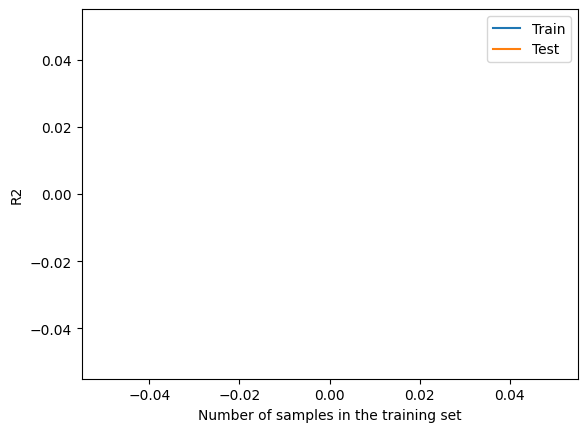

In [61]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="R2")
display.plot()
plt.show()

In [58]:
train_scores

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])